# Week 9 Assignment Part 2 using midterm project

[113065526]

In [14]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
fernandomikael_ukr_rus_path = kagglehub.dataset_download('fernandomikael/ukr-rus')

print('Data source import complete.')


Data source import complete.


In [15]:
!pip install pymupdf

In [16]:
import pymupdf
import re
import nltk
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
import random
import gdown

In [17]:
def load_pdf(pdf_path):
  try:
    doc = pymupdf.open(pdf_path, filetype="pdf")
    return doc
  except FileNotFoundError:
    print(f"Error: PDF file not found at '{pdf_path}'")
    return None
  except Exception as e:
    print(f"An error occurred while loading the PDF: {e}")
    return None

In [18]:
def clean_text(text):
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'-\s+', '', text)
    text = re.sub(r'<[^>]+>', '', text)
    return text.strip()

In [19]:
def extract_text_by_page(doc, max_pages=40):
    formatted_full_text = []
    ## https://medium.com/@aint-that-easy/aint-that-easy-5-rag-for-pdf-excel-and-web-9282c910a467

    total_items = len(doc)
    total_pages = min(len(doc), max_pages)

    for page_number, page in enumerate(doc):
        if page_number >= max_pages:
            break
        try:
            this_text = clean_text(page.get_text())

            # Extract tables
            tables = page.find_tables()
            for table in tables:
                df = table.to_pandas()
                this_text += "\nTable:\n" + df.to_string() + "\n"


            formatted_full_text.append({
                        "page": page_number+1,
                        "content": this_text
                    })

            # Update progress
            progress = (page_number + 1) / total_pages
            print(progress)
            print(f"Processing {page_number + 1}/{total_pages} pages with document (max_pages:{max_pages})...")

        except Exception as e:
            print(f"(extract_text_by_page) Error processing page {page}: {e}")

    print("Processing complete!")

    return formatted_full_text

In [20]:
pdf_path = "/kaggle/input/ukr-rus/ukr_rus.pdf"

In [21]:
# Load PDF
doc = load_pdf(pdf_path)

# Extract text from the PDF
full_text = extract_text_by_page(doc, max_pages=len(doc))  # Process full PDF

0.009708737864077669
Processing 1/103 pages with document (max_pages:103)...
0.019417475728155338
Processing 2/103 pages with document (max_pages:103)...
0.02912621359223301
Processing 3/103 pages with document (max_pages:103)...
0.038834951456310676
Processing 4/103 pages with document (max_pages:103)...
0.04854368932038835
Processing 5/103 pages with document (max_pages:103)...
0.05825242718446602
Processing 6/103 pages with document (max_pages:103)...
0.06796116504854369
Processing 7/103 pages with document (max_pages:103)...
0.07766990291262135
Processing 8/103 pages with document (max_pages:103)...
0.08737864077669903
Processing 9/103 pages with document (max_pages:103)...
0.0970873786407767
Processing 10/103 pages with document (max_pages:103)...
0.10679611650485436
Processing 11/103 pages with document (max_pages:103)...
0.11650485436893204
Processing 12/103 pages with document (max_pages:103)...
0.1262135922330097
Processing 13/103 pages with document (max_pages:103)...
0.13592

In [24]:
from transformers import pipeline
import re
import pandas as pd
from datetime import datetime
import nltk
nltk.download('punkt_tab')
nltk.download('punkt')

# Specify the model explicitly
model_name = "distilbert-base-uncased-finetuned-sst-2-english"

# Load the pretrained BERT sentiment analysis pipeline from Hugging Face
sentiment_analyzer = pipeline('sentiment-analysis', model=model_name)

def extract_dates_and_sentiment_with_bert(extracted_text):
    # Updated regular expression to match "Day Month Year" format, but extract only "Month Year"
    date_pattern = r"\b(\d{1,2})\s([A-Za-z]+)\s(\d{4})\b"  # Matches "16 March 2022" and captures Month and Year

    # Container for results
    date_sentiment_data = []

    for page in extracted_text:
        content = page["content"]
        # Find all dates in the text
        dates = re.findall(date_pattern, content)

        # Split the text into sentences or paragraphs and analyze sentiment
        sentences = nltk.sent_tokenize(content)

        for date in dates:
            day, month, year = date
            try:
                # Attempt to parse the date and convert to datetime object
                date_obj = datetime.strptime(f"{month} {year}", '%B %Y')
                year_month = date_obj.strftime('%Y-%m')  # Format as Year-Month (e.g., '2022-03')
            except Exception as e:
                print(f"Error parsing date '{month} {year}': {e}")
                continue

            # Calculate sentiment using BERT for each sentence
            sentiment = 0
            sentiment_count = 0
            for sentence in sentences:
                # Use BERT to analyze sentiment of the sentence
                result = sentiment_analyzer(sentence)

                # BERT sentiment analysis returns a label ('POSITIVE' or 'NEGATIVE') with score
                label = result[0]['label']
                sentiment_value = 1 if label == 'POSITIVE' else -1  # Convert sentiment to +1 or -1
                sentiment += sentiment_value
                sentiment_count += 1

            # If there are sentences to analyze, calculate the average sentiment
            avg_sentiment = sentiment / sentiment_count if sentiment_count > 0 else 0

            # Append the result
            date_sentiment_data.append({
                'Year-Month': year_month,
                'Sentiment': avg_sentiment
            })

    # Convert to DataFrame
    sentiment_df = pd.DataFrame(date_sentiment_data)
    return sentiment_df

# Call function to analyze sentiment for extracted text using BERT
sentiment_df = extract_dates_and_sentiment_with_bert(full_text[4:-1])

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cuda:0
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [25]:
# Display the result
print(sentiment_df)

    Year-Month  Sentiment
0      2025-02  -0.360000
1      2022-02  -0.360000
2      2022-02  -0.360000
3      2022-02  -0.360000
4      2022-02  -0.360000
..         ...        ...
642    2025-02   0.454545
643    2025-02  -0.777778
644    2025-02  -0.777778
645    2025-02  -0.777778
646    2025-02  -0.777778

[647 rows x 2 columns]


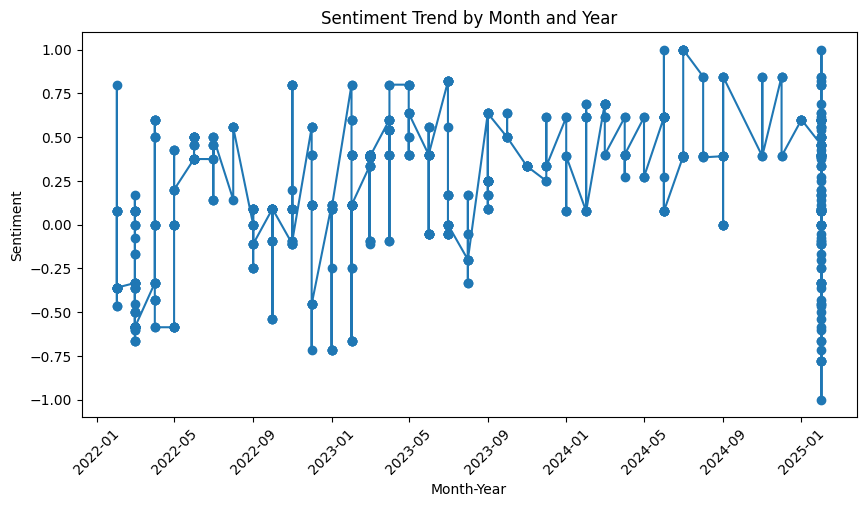

In [26]:
# Optional: Visualize the sentiment over time using a line plot
import matplotlib.pyplot as plt

sentiment_df['Year-Month'] = pd.to_datetime(sentiment_df['Year-Month'], format='%Y-%m')
sentiment_df = sentiment_df.sort_values('Year-Month')

plt.figure(figsize=(10, 5))
plt.plot(sentiment_df['Year-Month'], sentiment_df['Sentiment'], marker='o')
plt.title('Sentiment Trend by Month and Year')
plt.xlabel('Month-Year')
plt.ylabel('Sentiment')
plt.xticks(rotation=45)
plt.show()

         Date  Sentiment
0  2022-02-01  -0.175807
1  2022-03-01  -0.371410
2  2022-04-01  -0.002224
3  2022-05-01  -0.075344
4  2022-06-01   0.431302
5  2022-07-01   0.367473
6  2022-08-01   0.486772
7  2022-09-01  -0.040404
8  2022-10-01  -0.062937
9  2022-11-01   0.212015
10 2022-12-01   0.060649
11 2023-01-01  -0.176851
12 2023-02-01   0.136782
13 2023-03-01   0.308117
14 2023-04-01   0.486787
15 2023-05-01   0.596104
16 2023-06-01   0.241073
17 2023-07-01   0.252849
18 2023-08-01  -0.123860
19 2023-09-01   0.299784
20 2023-10-01   0.538961
21 2023-11-01   0.333333
22 2023-12-01   0.382392
23 2024-01-01   0.319883
24 2024-02-01   0.414392
25 2024-03-01   0.617965
26 2024-04-01   0.437317
27 2024-05-01   0.408798
28 2024-06-01   0.436850
29 2024-07-01   0.626161
30 2024-08-01   0.503344
31 2024-09-01   0.382163
32 2024-11-01   0.618729
33 2024-12-01   0.664214
34 2025-01-01   0.600000
35 2025-02-01   0.149296


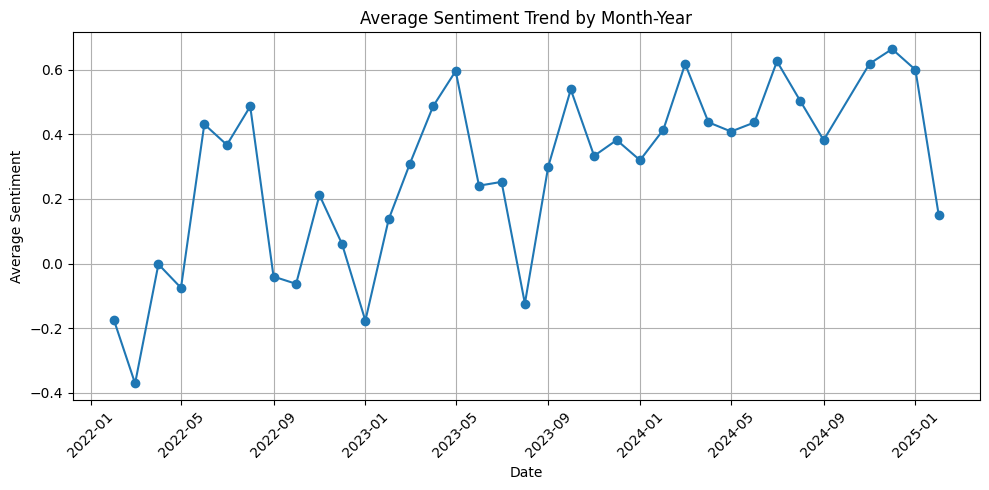

In [27]:
# Convert 'Year-Month' to datetime for proper grouping and sorting
sentiment_df['Year-Month'] = pd.to_datetime(sentiment_df['Year-Month'], format='%Y-%m')

# Group by Year-Month and average the sentiment
monthly_avg_sentiment = sentiment_df.groupby('Year-Month')['Sentiment'].mean().reset_index()

# Sort by date just in case
monthly_avg_sentiment = monthly_avg_sentiment.sort_values('Year-Month')

monthly_avg_sentiment.rename(columns={'Year-Month': 'Date'}, inplace=True)

# Display the result
print(monthly_avg_sentiment)

# Optional: Plot the averaged sentiment trend
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(monthly_avg_sentiment['Date'], monthly_avg_sentiment['Sentiment'], marker='o')
plt.title('Average Sentiment Trend by Month-Year')
plt.xlabel('Date')
plt.ylabel('Average Sentiment')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [28]:
monthly_avg_sentiment.to_csv('monthly_avg_sentiment.csv', index=False)

In [29]:
import os
import pandas as pd

# Path to the folder (adjust to match your dataset name)
folder_path = "/kaggle/input/ukr-rus/stock_market"

# Dictionary to store DataFrames for each stock
stock_dfs = {}

# Loop through the folder and read each CSV file
for filename in os.listdir(folder_path):
    if filename.endswith(".csv"):
        stock_name = filename.replace("_monthly_data.csv", "")
        file_path = os.path.join(folder_path, filename)
        stock_dfs[stock_name] = pd.read_csv(file_path)

# Show stock names loaded
print(stock_dfs.keys())


dict_keys(['AAPL_Tech', 'HII_Defense', 'AMD_Tech', 'CW_Defense', 'FMC_Agriculture', 'NVDA_Tech', 'MOS_Agriculture', 'DE_Agriculture', 'TDG_Defense', 'BA_Defense', 'META_Tech', 'OXY_OilGas', 'KMI_OilGas', 'AGCO_Agriculture', 'LMT_Defense', 'SMG_Agriculture', 'COP_OilGas', 'MSFT_Tech', 'CRM_Tech', 'LHX_Defense', 'GD_Defense', 'EOG_OilGas', 'ADM_Agriculture', 'AXON_Defense', 'HES_OilGas', 'IBM_Tech', 'NOC_Defense', 'TSN_Agriculture', 'GOOGL_Tech', 'XOM_OilGas', 'DVN_OilGas', 'CF_Agriculture', 'CTVA_Agriculture', 'CVX_OilGas', 'ORCL_Tech', 'INTC_Tech', 'BG_Agriculture', 'RTX_Defense'])


In [30]:
# Convert to datetime and extract Year-Month only
for stock_name, df in stock_dfs.items():
    df['Date'] = pd.to_datetime(df['Date'])
    df['Date'] = df['Date'].dt.to_period('M').astype(str)  # Converts to 'YYYY-MM'
    stock_dfs[stock_name] = df

In [31]:
# Preview one of the DataFrames (e.g., AAPL)
print(stock_dfs['AAPL_Tech'].head())

      Date        Open        High         Low       Close      Volume  \
0  2021-12  164.599805  178.997875  155.086281  174.516296  2444766700   
1  2022-01  174.771797  179.793919  152.039567  171.774246  2108446000   
2  2022-02  171.017480  173.612078  149.385999  162.280365  1627516300   
3  2022-03  162.073848  176.746111  147.706655  171.825836  2180800100   
4  2022-04  171.255053  175.643944  152.902437  155.136230  1687795600   

   High_Low_Diff  Monthly_Return  Volume_Change  
0      23.911593             NaN            NaN  
1      27.754352       -0.015712      -0.137568  
2      24.226079       -0.055270      -0.228097  
3      29.039456        0.058821       0.339956  
4      22.741507       -0.097131      -0.226066  


In [32]:
# Define the date range for filtering
start_date = '2022-01-01'
end_date = '2025-01-31'

# List to store the correlation results
correlation_results = []

# Iterate over each stock (each key in stock_dfs dictionary)
for stock_key, stock_data in stock_dfs.items():
    # Ensure the stock data has the correct date format
    stock_data['Date'] = pd.to_datetime(stock_data['Date'])

    # Filter the stock data based on the date range
    filtered_stock_data = stock_data[(stock_data['Date'] >= start_date) & (stock_data['Date'] <= end_date)]

    # Ensure the sentiment data is in the correct date range as well
    monthly_avg_sentiment['Date'] = pd.to_datetime(monthly_avg_sentiment['Date'])
    filtered_sentiment_data = monthly_avg_sentiment[(monthly_avg_sentiment['Date'] >= start_date) &
                                                    (monthly_avg_sentiment['Date'] <= end_date)]

    # Merge the stock data with the sentiment data based on the 'Date'
    merged_data = pd.merge(filtered_stock_data[['Date', 'Monthly_Return']],
                           filtered_sentiment_data[['Date', 'Sentiment']], on='Date', how='inner')

    # Calculate the correlation between Monthly_Return and Sentiment
    correlation = merged_data[['Monthly_Return', 'Sentiment']].corr().iloc[0, 1]

    # Append the correlation result to the list
    correlation_results.append({'Stock': stock_key, 'Correlation': correlation})

# Create a DataFrame to hold the correlation results
correlation_df = pd.DataFrame(correlation_results)

# Split the "Stock" column into two separate columns "Stock" and "Sector"
correlation_df[['Stock', 'Sector']] = correlation_df['Stock'].str.split('_', expand=True)

correlation_df = correlation_df[['Sector', 'Stock', 'Correlation']]

correlation_df = correlation_df.sort_values(by='Sector', ascending=True)

# Display the dataframe with correlations
print(correlation_df)

         Sector  Stock  Correlation
27  Agriculture    TSN     0.026320
31  Agriculture     CF    -0.196338
4   Agriculture    FMC    -0.204666
6   Agriculture    MOS    -0.399728
7   Agriculture     DE    -0.014865
22  Agriculture    ADM    -0.135769
36  Agriculture     BG    -0.212296
32  Agriculture   CTVA    -0.148702
13  Agriculture   AGCO    -0.279940
15  Agriculture    SMG     0.045332
37      Defense    RTX     0.110258
26      Defense    NOC    -0.067169
23      Defense   AXON     0.102213
20      Defense     GD    -0.148660
19      Defense    LHX    -0.193931
14      Defense    LMT    -0.114812
9       Defense     BA     0.122939
8       Defense    TDG    -0.000060
3       Defense     CW    -0.106923
1       Defense    HII     0.084078
16       OilGas    COP    -0.245905
12       OilGas    KMI     0.001058
11       OilGas    OXY    -0.440137
33       OilGas    CVX    -0.338774
21       OilGas    EOG    -0.142829
24       OilGas    HES    -0.308927
30       OilGas    DVN    -0

<ipython-input-33-a274af14c503>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Sector', y='Correlation', data=correlation_df, palette='Set2')


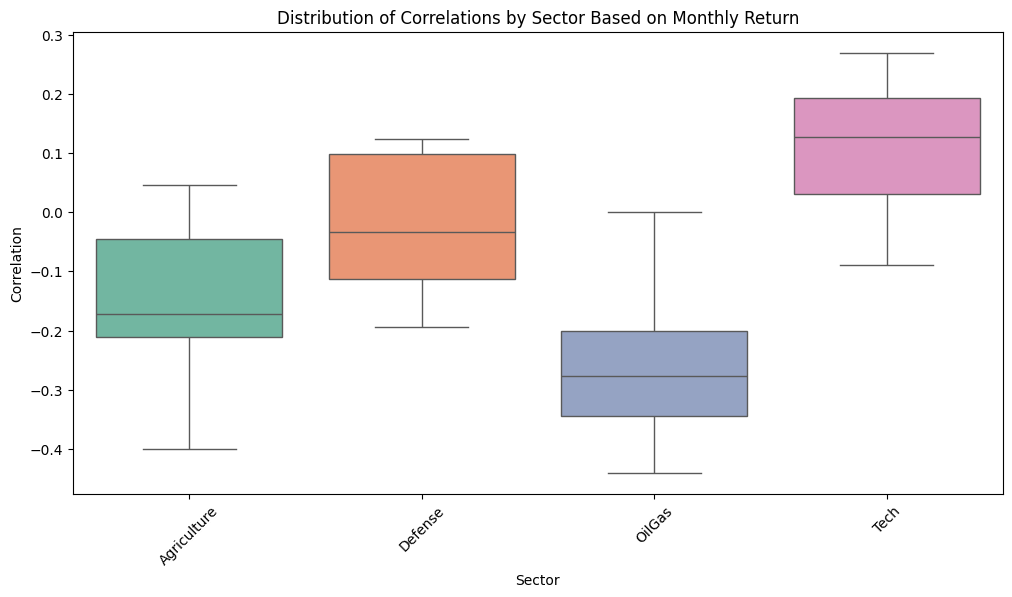

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a box plot
plt.figure(figsize=(12, 6))
sns.boxplot(x='Sector', y='Correlation', data=correlation_df, palette='Set2')

# Adding title and labels
plt.title('Distribution of Correlations by Sector Based on Monthly Return')
plt.xlabel('Sector')
plt.ylabel('Correlation')

# Display the plot
plt.xticks(rotation=45)
plt.show()


In [34]:
# Define the date range for filtering
start_date = '2022-01-01'
end_date = '2025-01-31'

# List to store the correlation results
correlation_results = []

# Iterate over each stock (each key in stock_dfs dictionary)
for stock_key, stock_data in stock_dfs.items():
    # Ensure the stock data has the correct date format
    stock_data['Date'] = pd.to_datetime(stock_data['Date'])

    # Filter the stock data based on the date range
    filtered_stock_data = stock_data[(stock_data['Date'] >= start_date) & (stock_data['Date'] <= end_date)]

    # Ensure the sentiment data is in the correct date range as well
    monthly_avg_sentiment['Date'] = pd.to_datetime(monthly_avg_sentiment['Date'])
    filtered_sentiment_data = monthly_avg_sentiment[(monthly_avg_sentiment['Date'] >= start_date) &
                                                    (monthly_avg_sentiment['Date'] <= end_date)]

    # Merge the stock data with the sentiment data based on the 'Date'
    merged_data = pd.merge(filtered_stock_data[['Date', 'Volume_Change']],
                           filtered_sentiment_data[['Date', 'Sentiment']], on='Date', how='inner')

    # Calculate the correlation between Monthly_Return and Sentiment
    correlation = merged_data[['Volume_Change', 'Sentiment']].corr().iloc[0, 1]

    # Append the correlation result to the list
    correlation_results.append({'Stock': stock_key, 'Correlation': correlation})

# Create a DataFrame to hold the correlation results
correlation_df = pd.DataFrame(correlation_results)

# Split the "Stock" column into two separate columns "Stock" and "Sector"
correlation_df[['Stock', 'Sector']] = correlation_df['Stock'].str.split('_', expand=True)

correlation_df = correlation_df[['Sector', 'Stock', 'Correlation']]

correlation_df = correlation_df.sort_values(by='Sector', ascending=True)

# Display the dataframe with correlations
print(correlation_df)

         Sector  Stock  Correlation
27  Agriculture    TSN     0.049253
31  Agriculture     CF    -0.085611
4   Agriculture    FMC    -0.151808
6   Agriculture    MOS    -0.297162
7   Agriculture     DE    -0.038116
22  Agriculture    ADM    -0.216156
36  Agriculture     BG    -0.108159
32  Agriculture   CTVA    -0.347839
13  Agriculture   AGCO    -0.141817
15  Agriculture    SMG    -0.174063
37      Defense    RTX    -0.057409
26      Defense    NOC    -0.249686
23      Defense   AXON     0.130615
20      Defense     GD    -0.028985
19      Defense    LHX     0.060559
14      Defense    LMT    -0.107978
9       Defense     BA    -0.057282
8       Defense    TDG    -0.145972
3       Defense     CW    -0.275400
1       Defense    HII    -0.003818
16       OilGas    COP     0.000097
12       OilGas    KMI    -0.044082
11       OilGas    OXY    -0.214556
33       OilGas    CVX    -0.143007
21       OilGas    EOG     0.018647
24       OilGas    HES     0.073743
30       OilGas    DVN     0

<ipython-input-35-c71939f8e434>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Sector', y='Correlation', data=correlation_df, palette='Set2')


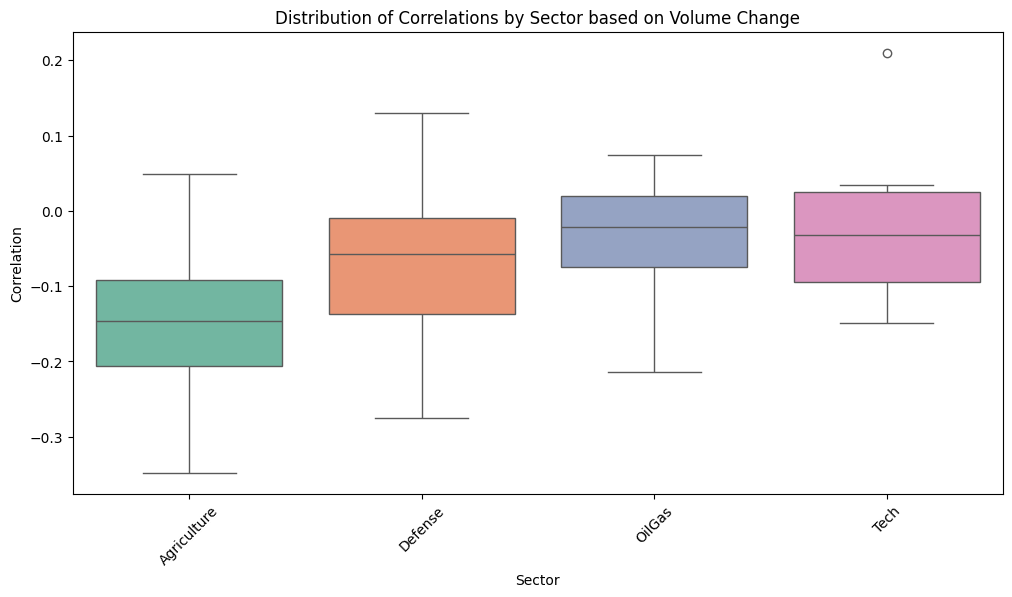

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a box plot
plt.figure(figsize=(12, 6))
sns.boxplot(x='Sector', y='Correlation', data=correlation_df, palette='Set2')

# Adding title and labels
plt.title('Distribution of Correlations by Sector based on Volume Change')
plt.xlabel('Sector')
plt.ylabel('Correlation')

# Display the plot
plt.xticks(rotation=45)
plt.show()

In [58]:
# === 🔧 修改區塊：Chatbot 回應核心函數 ===
def generate_response(user_input):
    user_input = user_input.lower()

    if "sentiment" in user_input and ("month" in user_input or "date" in user_input):
        match = re.search(r"(20\d{2}-\d{2})", user_input)
        if match:
            date_query = match.group(1)
            filtered = monthly_avg_sentiment[monthly_avg_sentiment['Date'] == date_query]
            if not filtered.empty:
                score = filtered.iloc[0]['Sentiment']
                return f"The average sentiment in {date_query} was {score:.2f}."
            else:
                return "No sentiment data found for that month."

    elif "correlation" in user_input and any(keyword in user_input for keyword in ["return", "volume", "stock"]):
        for stock_key in stock_dfs.keys():
            if stock_key.lower() in user_input:
                if "volume" in user_input:
                    vol_corr = correlation_df[correlation_df['Stock'] == stock_key]
                    if not vol_corr.empty:
                        corr_value = vol_corr.iloc[0]['Correlation']
                        return f"The correlation between sentiment and trading volume for {stock_key} is {corr_value:.2f}."
                else:
                    ret_corr = correlation_df[correlation_df['Stock'] == stock_key]
                    if not ret_corr.empty:
                        corr_value = ret_corr.iloc[0]['Correlation']
                        return f"The correlation between sentiment and monthly return for {stock_key} is {corr_value:.2f}."
        return "Sorry, I couldn't find that stock in our dataset."

    elif "sector" in user_input:
        sectors = correlation_df['Sector'].unique()
        for sector in sectors:
            if sector.lower() in user_input:
                avg_corr = correlation_df[correlation_df['Sector'] == sector]['Correlation'].mean()
                return f"The average sentiment correlation for the {sector} sector is {avg_corr:.2f}."

    elif "help" in user_input:
        return (
            "You can ask things like:\n"
            "- 'What was the sentiment in 2022-03?'\n"
            "- 'What's the correlation between sentiment and AAPL_Tech monthly return?'\n"
            "- 'How is the trading volume related to sentiment for TSLA_Tech?'\n"
            "- 'What's the average correlation for the Finance sector?'"
        )

    else:
        return "I'm your Ukraine-Russia War & Stock Market Analysis assistant. Type 'help' to see what you can ask me!"

In [59]:
!pip install streamlit
import streamlit as st

In [60]:
# 顯示標題
st.title("📊 Stock & Sentiment Chatbot")

# 使用 chat_input 接收使用者問題
user_input = st.chat_input("Ask me about sentiment and stock trends...")

# 顯示使用者輸入
if user_input:
    st.chat_message("user").write(user_input)
    response = generate_response(user_input)
    st.chat_message("assistant").write(response)


2025-05-05 12:55:02.609 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-05 12:55:02.610 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-05 12:55:02.611 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-05 12:55:02.611 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-05 12:55:02.612 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-05 12:55:02.613 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-05 12:55:02.614 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


**Answer Block:**

The implementation of war sentiment analysis via chatbot interfaces improves human-computer interaction by allowing natural language-based data exploration, significantly lowering the technical threshold for users. This methodology demonstrates cross-domain applicability in education, financial markets, and policy studies, with scalable deployment options for web platforms or enterprise systems. Future development pathways include voice interaction modules and multilingual support capabilities.